In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Instructions for the presentations

- one presentation per group (we have 3 groups)
- split the presentation evenly between group members (everyone must present at least a few minutes)
- each presentation should be 20 min max
- prepare slides
- content:
   * introduction: why do we care? + setup of the problem + outline of the presentation
   * results; be creative in terms of how you present your results; tell me an interesting story, with transitions between sub-sections of your results
   * conclusions: what is the take-home message from these exercises? what have we learned about the brain in doing all this? what could be interesting extensions of this work?

# 2. Generation of Poisson spike trains

In [2]:
n=1000       # number of neurons
t=2          # total duration [s]
dt=1e-4      # step size [s]
n_bins=int(t/dt)  # number of time bins
rx = 10      # firing rate of each neuron

# generates random Poisson spike trains (they are only "Poisson" in the limit of small step size)
spikes = np.random.binomial(1, rx*dt, size=(n,n_bins))

Empirically estimated firing rate for each neuron: 

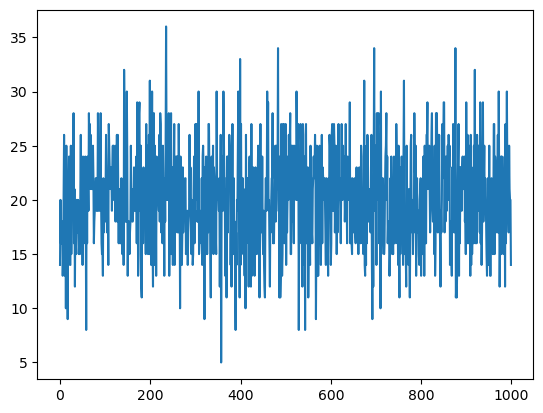

In [3]:
plt.plot(np.sum(spikes,axis=1))
plt.show()

# 3. Single LIF neuron with single Poisson input train

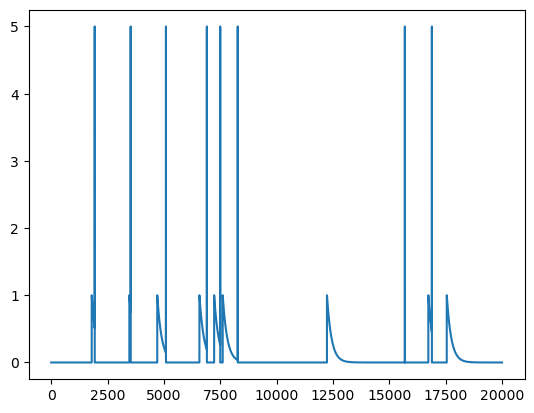

In [4]:
# parameters of the neurons
tau = 20e-3   # membrane time constant [s]
w = 1       # synaptic weight
v_thresh = 1

# generate input spikes
s_in = np.random.binomial(1, rx*dt, size=n_bins)

# integrate the LIF + spike & reset dynamics
v = np.zeros(n_bins)   # to store the voltage
s_out = np.zeros(n_bins)
has_just_spiked = False

for k in range(1, n_bins):
    if has_just_spiked:
        v[k] = 0
        has_just_spiked = False
    else:
        v[k] = v[k-1]*(1-dt/tau) + (w * s_in[k])
    # check if we need to generate an output spike
    if v[k] > v_thresh:
        v[k] = 5
        has_just_spiked = True
        s_out[k] = 1

# plot the result
plt.plot(v)
plt.show()

# 4. Single LIF neuron, many excitatory inputs

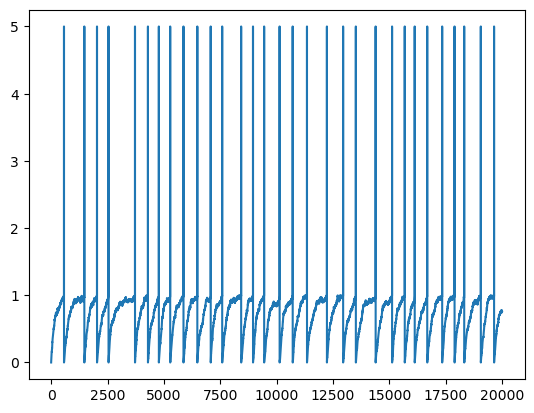

In [5]:
# parameters of the neurons
v_thresh = 1
tau = 20e-3         # membrane time constant [s]
K = 1000            # number of input synapses
w = 51000 / K   # synaptic weight

# generate input spikes
s_in = np.random.binomial(1, rx*dt, size=(K,n_bins))
s_in_total = np.sum(s_in, axis=0)
# s_in_total_mean = np.mean(s_in_total)

# integrate the LIF + spike & reset dynamics
v = np.zeros(n_bins)   # to store the voltage
s_out = np.zeros(n_bins)
has_just_spiked = False

for k in range(1, n_bins):
    if has_just_spiked:
        v[k] = 0
        has_just_spiked = False
    else:
        v[k] = v[k-1]*(1-dt/tau) + dt * (w * s_in_total[k])
    # check if we need to generate an output spike
    if v[k] > v_thresh:
        v[k] = 5
        has_just_spiked = True
        s_out[k] = 1

# plot the result
plt.plot(v)
plt.show()

In [6]:
# 5. Single LIF neuron with many E and I Poisson inputs
# parameters of the neurons
v_thresh = 1
tau = 20e-3         # membrane time constant [s]
K = 1000            # number of input synapses
w = 1.15   # synaptic weight
average = np.zeros((11))
sum = 0.0

for count in range(1, 11):
    # generate input spikes
    E_in = np.random.binomial(1, rx*dt, size=(K,n_bins))
    E_in_total = np.sum(E_in, axis=0)
    I_in = np.random.binomial(1, rx*dt, size=(K,n_bins))
    I_in_total = np.sum(I_in, axis=0)

    # integrate the LIF + spike & reset dynamics
    v = np.zeros(n_bins)   # to store the voltage
    s_out = np.zeros(n_bins)
    has_just_spiked = False
    for k in range(1, n_bins):
        if has_just_spiked:
            v[k] = 0
            has_just_spiked = False
        else:
            v[k] = v[k-1]*(1-dt/tau) + (w / np.sqrt(K) * (E_in_total[k] - I_in_total[k]))
            # print(E_in_total[k] - I_in_total[k])
        # check if we need to generate an output spike
        if v[k] > v_thresh:
            v[k] = 5
            has_just_spiked = True
            s_out[k] = 1
        
    sum = sum + np.sum(s_out)
    #print(sum, count)
    average[count] = sum / count

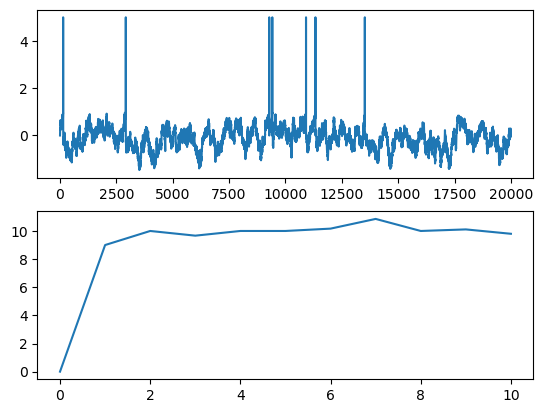

In [7]:
#print(average)
# plot the result
plt.subplot(2,1,1)
#plt.xlim(1,1000)
#plt.ylim(0,1)
plt.plot(v)
plt.subplot(2,1,2)
plt.plot(average)
plt.show()

In [8]:
# 6. Full network
# parameters of the neurons

import numba

@numba.jit(nopython=True)
def LIF():
    v_thresh = 1
    tau = 20e-3         # membrane time constant [s]
    N = 1000
    K = 100         # number of input synapses
    J_EE = J_IE = 1 
    J_EI = -2.5 
    J_II = -2 
    J_EX = 2 
    J_IX = 1 

    # generate input spikes
    E_V = np.zeros((N,n_bins), dtype=numba.float64)
    I_V = np.zeros((N,n_bins), dtype=numba.float64)
    
    def build_connections():
        in_index = np.zeros((N,K), dtype=numba.int8)
        for i in range(0, N):
            in_index[i] = np.random.choice(N, K, replace=False)
        return in_index


    EX_index = build_connections()
    EE_index = build_connections()
    EI_index = build_connections()
    IX_index = build_connections()
    IE_index = build_connections()
    II_index = build_connections()
    
    EX_total = np.zeros((N,n_bins), dtype=numba.int8)
    EE_total = np.zeros((N,n_bins), dtype=numba.int8)
    EI_total = np.zeros((N,n_bins), dtype=numba.int8)
    IX_total = np.zeros((N,n_bins), dtype=numba.int8)
    IE_total = np.zeros((N,n_bins), dtype=numba.int8)
    II_total = np.zeros((N,n_bins), dtype=numba.int8)
    
    X_out = np.random.binomial(1, rx*dt, size=(N,n_bins))
    E_out = np.zeros((N,n_bins), dtype=numba.int8)
    I_out = np.zeros((N,n_bins), dtype=numba.int8)

    # integrate the LIF + spike & reset dynamics
    for i in range(1, n_bins):
        for j in range(0, N):
            EX_total[j][i] = np.sum(X_out[EX_index[j], i - 1])
            EE_total[j][i] = np.sum(E_out[EE_index[j], i - 1])
            EI_total[j][i] = np.sum(I_out[EI_index[j], i - 1])
            IX_total[j][i] = np.sum(X_out[IX_index[j], i - 1])
            IE_total[j][i] = np.sum(E_out[IE_index[j], i - 1])
            II_total[j][i] = np.sum(I_out[II_index[j], i - 1])
            if E_V[j][i - 1] >= v_thresh:
                E_V[j][i] = 0
            else:
                E_V[j][i] = E_V[j][i - 1] * (1 - dt / tau) +  (J_EE / np.sqrt(K) * EE_total[j][i] + J_EI / np.sqrt(K) * EI_total[j][i] + J_EX / np.sqrt(K) * EX_total[j][i])
                #print(EX_total[j][i])
                if E_V[j][i] >= v_thresh:
                    E_V[j][i] = 5
                    E_out[j][i] = 1
            if I_V[j][i - 1] >= v_thresh:
                I_V[j][i] = 0
            else:
                I_V[j][i] = I_V[j][i - 1] * (1 - dt / tau) +  (J_IE / np.sqrt(K) * IE_total[j][i] + J_II / np.sqrt(K) * II_total[j][i] + J_IX / np.sqrt(K) * IX_total[j][i])
                if I_V[j][i] >= v_thresh:
                    I_V[j][i] = 5
                    I_out[j][i] = 1
                    
    return E_V, I_V, IX_total, EE_total, EI_total, EX_total, X_out, E_out, I_out

E_V, I_V, IX_total, EE_total, EI_total, EX_total, X_out, E_out, I_out = LIF()

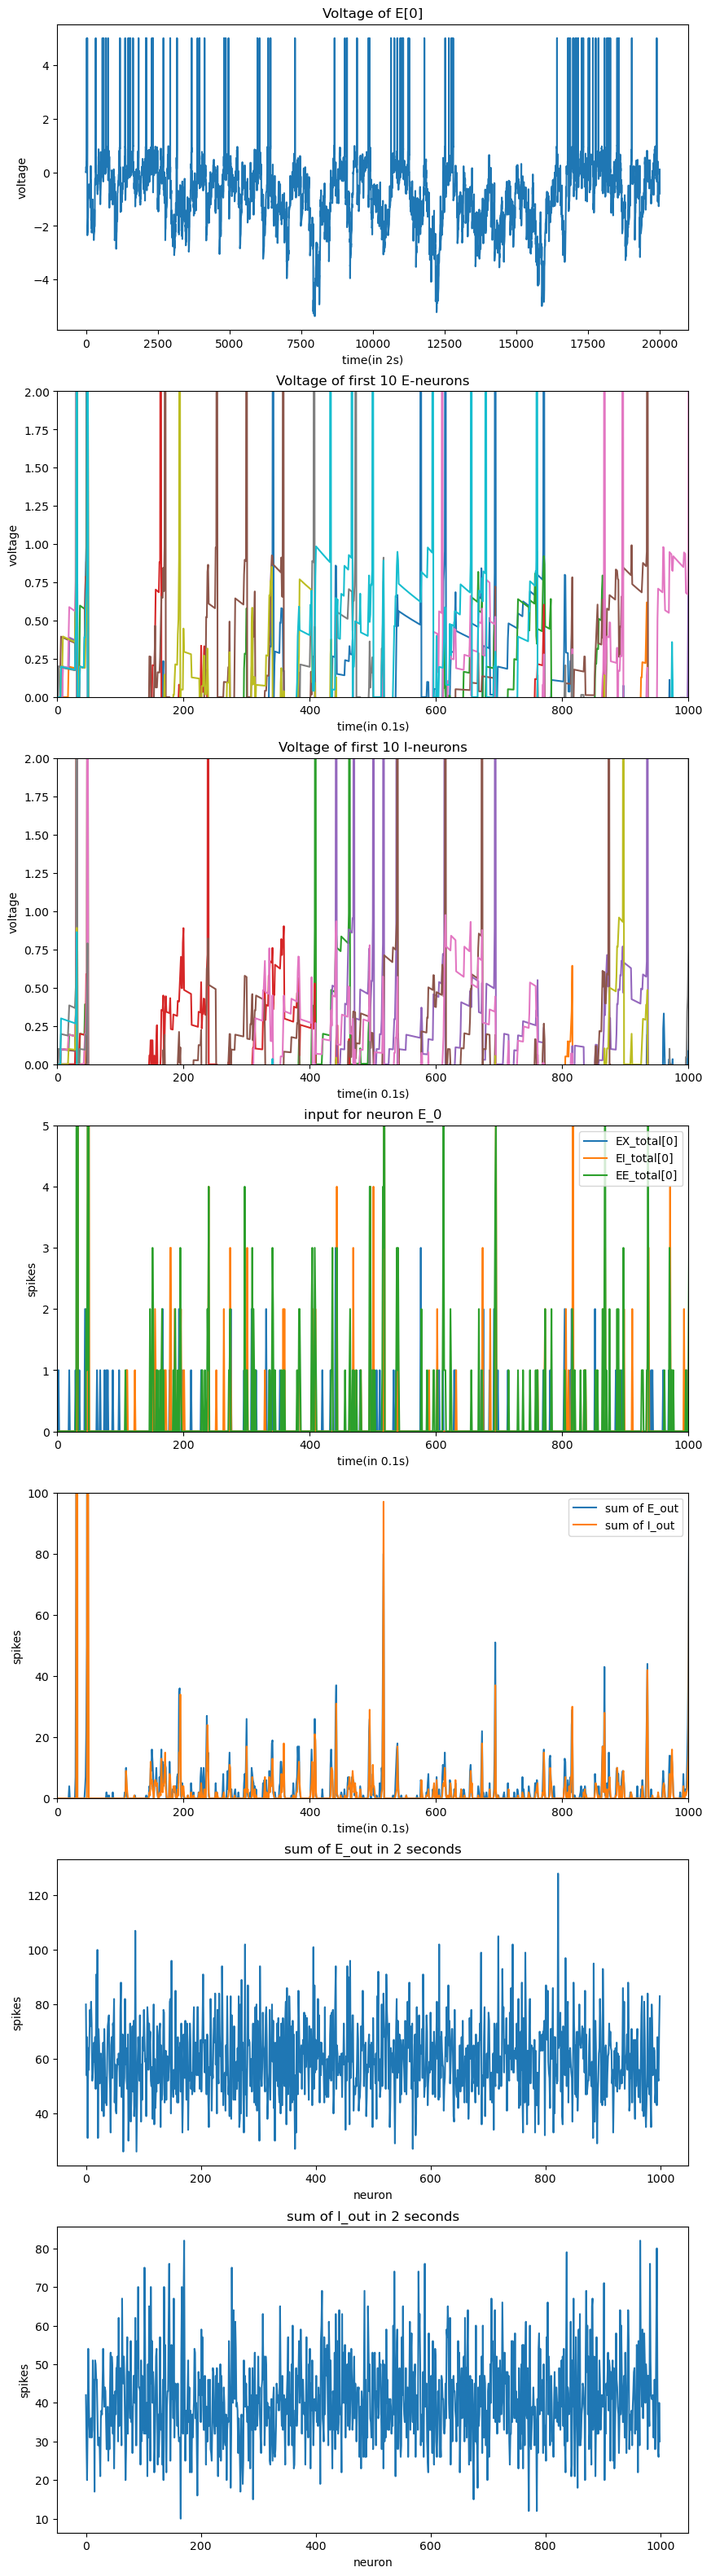

In [9]:
plt.figure(figsize=(10,40))
plt.subplot(7,1,1)
plt.ylabel('voltage')
plt.xlabel('time(in 2s)')
plt.plot(E_V[0])
plt.title('Voltage of E[0]')
plt.subplot(7,1,2)
plt.ylabel('voltage')
plt.xlabel('time(in 0.1s)')
for i in range(10):
    plt.plot(E_V[i])
plt.title('Voltage of first 10 E-neurons')
plt.xlim(0,1000)
plt.ylim(0,2)
plt.subplot(7,1,3)
plt.ylabel('voltage')
plt.xlabel('time(in 0.1s)')
for i in range(10):
    plt.plot(I_V[i])
plt.title('Voltage of first 10 I-neurons')
plt.xlim(0,1000)
plt.ylim(0,2)
plt.subplot(7,1,4)
x = np.arange(0,n_bins)
plt.xlim(0,1000)
plt.ylim(0,5)
plt.title('input for neuron E_0')
plt.ylabel('spikes')
plt.xlabel('time(in 0.1s)')
plt.plot(x, EX_total[0])
plt.plot(x, EI_total[0]) # 为什么EI_total和EX_total总是在同一时间暴增
plt.plot(x, EE_total[0])
plt.legend(['EX_total[0]', 'EI_total[0]','EE_total[0]'])
# 某时刻会有一波暴增，也不知道为什么
plt.subplot(7,1,5)
plt.xlim(0,1000)
plt.ylim(0,100)
plt.ylabel('spikes')
plt.xlabel('time(in 0.1s)')
plt.plot(x, np.sum(E_out, axis=0), x, np.sum(I_out, axis=0))
plt.legend(['sum of E_out','sum of I_out'])
plt.subplot(7,1,6)
plt.ylabel('spikes')
plt.xlabel('neuron')
plt.plot(np.sum(E_out, axis=1))
plt.title('sum of E_out in 2 seconds')
plt.subplot(7,1,7)
plt.ylabel('spikes')
plt.xlabel('neuron')
plt.plot(np.sum(I_out, axis=1))
plt.title('sum of I_out in 2 seconds')
plt.savefig('exe3')
plt.show()